# 色変換のサンプルコード

## 白色点変換

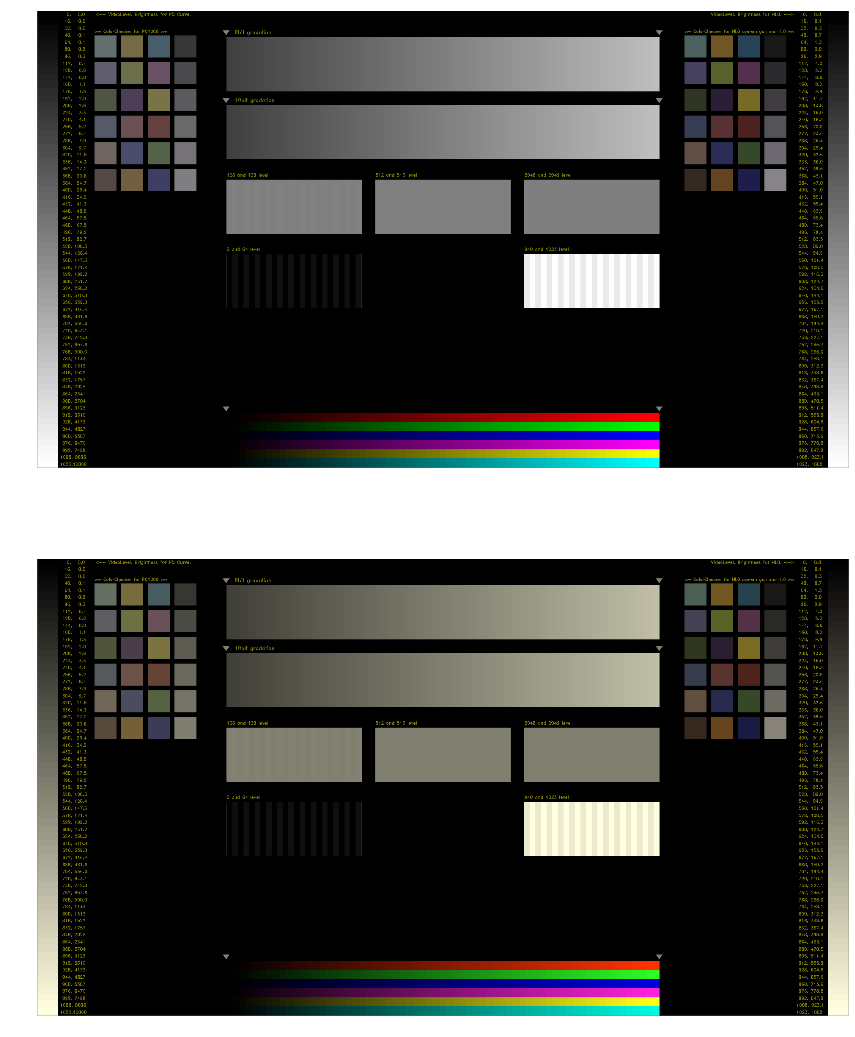

In [1]:
import matplotlib.pyplot as plt
import color_convert as cc
import numpy as np
import cv2
%matplotlib inline

# 画像ファイル読み込み
# --------------------------
img_file_name = "./figures/source.tif"
before_img = cv2.imread(img_file_name, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
""" OpenCV は RGB ではなく GBR の順序なので配列の入れ替えをする """
before_img = before_img[:, :, ::-1]  # GBR --> RGB 変換

# 変換のために 1.0 に正規化
# --------------------------
img_max_value = np.iinfo(before_img.dtype).max
after_img = before_img / img_max_value

# ガンマ解除してリニア空間に戻す
# --------------------------------
after_img = after_img ** 2.2

# D65 --> D50 に変換
# -------------------------
src = cc.const_d65_large_xyz
dst = cc.const_d50_large_xyz
convert_matrix = cc.get_white_point_conv_matrix(src, dst)
after_img = cc.color_cvt(after_img, convert_matrix)

# オーバーフロー、アンダーフローの処理
# --------------------------------------
"""
オーバーフロー処理も cc.color_cvt() に含めるべきかと思ったが
汎用性が減少するのでやめた。
"""
ng_idx_overflow = after_img > 1.0
ng_idx_underflow = after_img < 0.0
after_img[ng_idx_overflow] = 1.0
after_img[ng_idx_underflow] = 0.0

# ガンマをかけ直す
# ---------------------------------
after_img = after_img ** (1 / 2.2)

# 1.0 に正規化していたのを元に戻す
# ---------------------------------
after_img = np.round(after_img * img_max_value)
after_img = after_img.astype(before_img.dtype)  # 型をfloat型からint型へ

# 比較表示
# ---------------------------------
fig = plt.figure(figsize=(16, 18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.imshow(before_img / img_max_value)  # 整数型だと表示が乱れたので浮動小数点型にした
ax2.imshow(after_img / img_max_value)
plt.show()

## 色域変換

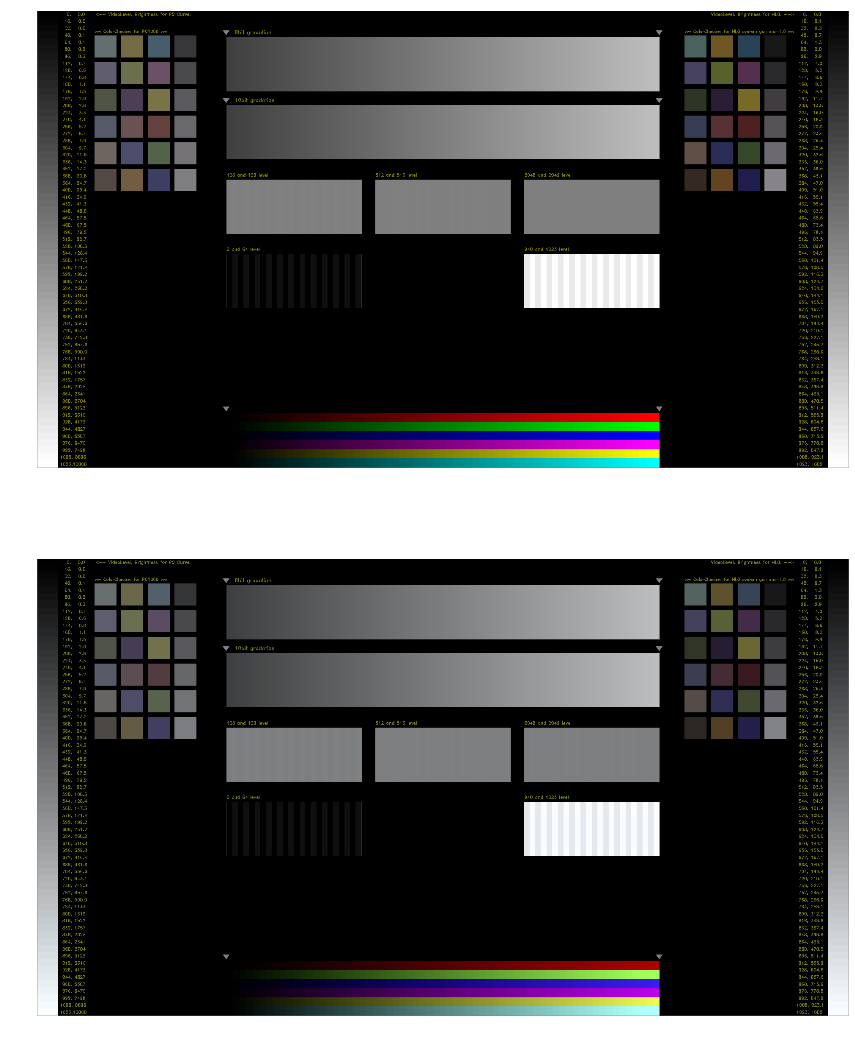

In [3]:
import matplotlib.pyplot as plt
import color_convert as cc
from scipy import linalg
import numpy as np
import cv2
import imp
%matplotlib inline

imp.reload(cc)

# 画像ファイル読み込み
# --------------------------
img_file_name = "./figures/source.tif"
before_img = cv2.imread(img_file_name, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
before_img = before_img[:, :, ::-1]  # GBR --> RGB 変換

# 変換のために 1.0 に正規化
# --------------------------
img_max_value = np.iinfo(before_img.dtype).max
after_img = before_img / img_max_value

# ガンマ解除してリニア空間に戻す
# --------------------------------
after_img = cc.rec709_to_linear(after_img)

# REC709 --> REC2020 に変換
# ---------------------------
src_gamut = cc.const_rec709_xy
src_white = cc.const_d65_large_xyz
dst_gamut = cc.const_rec2020_xy
dst_white = cc.const_d65_large_xyz
rec709_to_xyz_mtx = cc.get_rgb_to_xyz_matrix(src_gamut, src_white)
rec2020_to_xyz_mtx = cc.get_rgb_to_xyz_matrix(dst_gamut, dst_white)
xyz_to_rec2020_mtx = linalg.inv(rec2020_to_xyz_mtx)
convert_matrix = rec709_to_xyz_mtx.dot(xyz_to_rec2020_mtx)
after_img = cc.color_cvt(after_img, convert_matrix)

# オーバーフロー、アンダーフローの処理
# --------------------------------------
"""
オーバーフロー処理も cc.color_cvt() に含めるべきかと思ったが
汎用性が減少するのでやめた。
"""
ng_idx_overflow = after_img > 1.0
ng_idx_underflow = after_img < 0.0
after_img[ng_idx_overflow] = 1.0
after_img[ng_idx_underflow] = 0.0

# ガンマをかけ直す
# ---------------------------------
after_img = cc.linear_to_rec709(after_img)

# 1.0 に正規化していたのを元に戻す
# ---------------------------------
after_img = np.round(after_img * img_max_value)
after_img = after_img.astype(before_img.dtype)  # 型をfloat型からint型へ

# 比較表示
# ---------------------------------
fig = plt.figure(figsize=(16, 18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.imshow(before_img / img_max_value)  # 整数型だと表示が乱れたので浮動小数点型にした
ax2.imshow(after_img / img_max_value)
plt.show()